In [42]:
"""
Genetic algorithm to pilot a car on a circuit made of several check points:
- you can rotate the car between -20 and 20 degrees
- you can thrust between 0 and 100 (percentage)
- you cannot break for now

Interesting resources:
* http://files.magusgeek.com/csb/csb_en.html
* https://www.codingame.com/blog/genetic-algorithms-coders-strike-back-game/?utm_source=codingame&utm_medium=details-page&utm_campaign=cg-blog&utm_content=csb
* https://www.codingame.com/blog/evolutionary-trajectory-optimization/?utm_source=codingame&utm_medium=details-page&utm_campaign=cg-blog&utm_content=csb
* https://www.codingame.com/multiplayer/bot-programming/coders-strike-back
* https://en.wikipedia.org/wiki/Multi-agent_system

TODO - try other approaches like:
- neural nets (regression problem): but where do you get the data? CHECK https://www.docdroid.net/NgvoYFR/csb-nn-slides.pdf
- RL (and there you might be able to use neural nets)
"""

import copy
from dataclasses import *
import math
import numpy as np
from typing import *

%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy
from PIL import Image

In [60]:
Vector = np.ndarray

Angle = float
Mass = float
Speed = float

AngularSpeed = float
Thrust = float


@dataclass(frozen=True)
class Action:
    turn: AngularSpeed
    thrust: Thrust


@dataclass(frozen=True)
class Vehicle:
    mass: Mass
    position: Vector
    speed: Speed
    direction: Angle


def get_angle(vector):
    # Get angle from a vector (x, y)
    x, y = vector
    if x > 0: return np.arctan(y / x)
    if x < 0: return np.arctan(y / x) + (math.pi if y >= 0 else -math.pi)
    return math.pi / 2 if y >= 0 else -math.pi / 2


def constrain_between(value, low, high):
    if value < low:
        return low
    if value > high:
        return high
    return value

        
def move(vehicle: Vehicle, action: Action, time_step: float) -> Vehicle:
    """
    The formula is deduced from F = m * a = thrust
    => dv / dt = thrust / m
    => v(t+dt) = v(t) + thrust / m * dt
    """
        
    # TODO - The constraint is that the angle of thrust cannot be outside [-22 deg, 22 deg] of the current angle
    turn = constrain_between(action.turn, - math.pi / 8, math.pi / 8)
    new_direction = (vehicle.direction + turn * time_step) % (2 * math.pi)
    
    # Compute the acceleration
    dv_dt = np.array([
        action.thrust * math.cos(new_direction) / vehicle.mass,
        action.thrust * math.sin(new_direction) / vehicle.mass
    ])
    
    # Compute the speed
    speed = np.array([
        vehicle.speed * math.cos(vehicle.direction),
        vehicle.speed * math.sin(vehicle.direction)
    ])
    
    # Apply on the speed and position
    new_speed = speed + dv_dt * time_step
    new_pos = vehicle.position + new_speed * time_step
    speed_norm = math.sqrt(np.dot(new_speed, new_speed))
    return Vehicle(mass=vehicle.mass, position=new_pos, speed=speed_norm, direction=new_direction)
    

# TODO - game mecanics - plus production of an animated GIF

# TODO - represent the genome as sequence of N pairs (angle diff, thrust), with N being the prediction depth
# TODO - investigate on how to do the mutations and the crossover
# TODO - investigate on how to transform the genome into actual moves (you have difference between genes and the behavior)

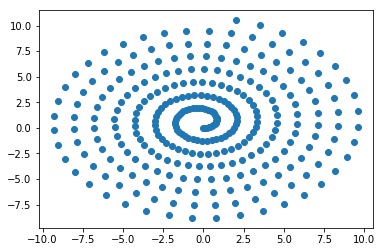

In [59]:
"""
Example of a crazy movement
"""

xs = []
ys = []
car = Vehicle(mass=2., position=np.array([0., 0.]), speed=1., direction=0.)
for action in [Action(turn=math.pi/2, thrust=1.)] * 300:
    xs.append(car.position[0])
    ys.append(car.position[1])
    car = move(car, action=action, time_step=0.1)

plt.scatter(xs, ys)